In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)

In [3]:
DATA_DIR = ''

train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

data = pd.concat([train_data, test_data], ignore_index=True, sort=False)

In [4]:
data.shape

(1309, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Поиск пропущенных значений
--

Так как общее количество строк — 1309, то мы явно видим наличие пропусков в данных.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

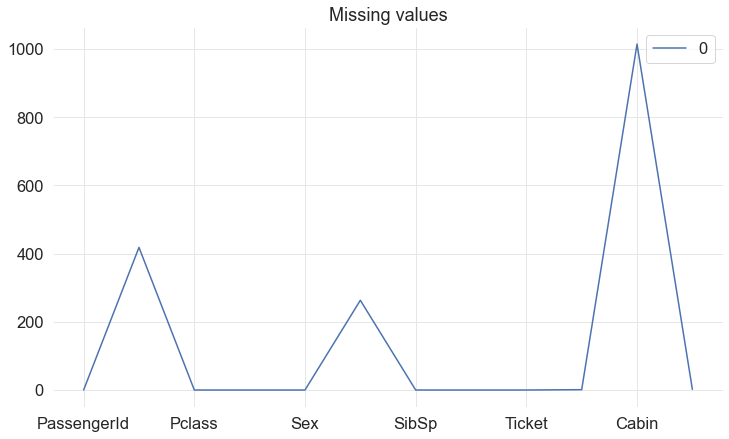

In [6]:
pd.DataFrame(data.isnull().sum()).plot.line().set_title("Missing values")
data.isnull().sum()

Столбцы с пропущенными данными:
--
- Survived
- Age
- Fare
- Cabin
- Embarked

1. Значения в столбце **Cabin** можно игнорировать, так как оно отсутствует почти на всей выборке данных
2. Пропущенные значения из колонки **Age** можно спрогнозировать на основе имени

Text(0.5, 1.0, 'Missing values — heatmap')

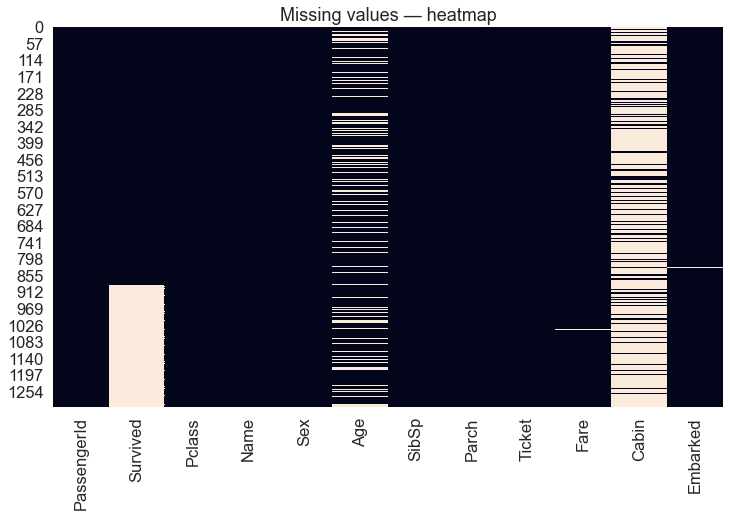

In [7]:
sns.heatmap(data.isnull(), cbar = False).set_title("Missing values — heatmap")

Получение уникальности данных
--
- **Survived** имеет 2 уникальных значения
- **Sex** имеет 2 уникальных значения
- **Pclass** имеет 3 уникальных значения
- **Embarked** имеет 3 уникальных значения

In [9]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Survived
--
Более 60% всех пассажиров погибло

<AxesSubplot:>

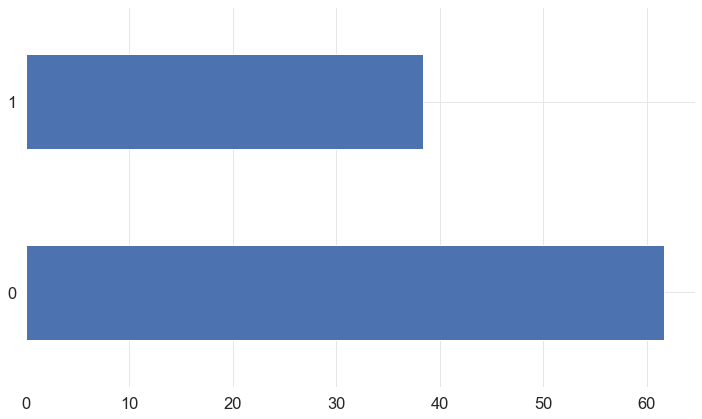

In [21]:
survived_percent = train_data.Survived.value_counts(normalize=True) * 100
survived_percent.plot.barh()

Pclass
--


<AxesSubplot:ylabel='Pclass'>

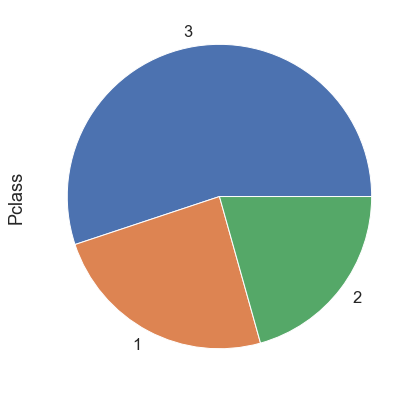

In [36]:
pclass_info = train_data.Pclass.value_counts()
pclass_info.plot.pie()

In [48]:
def get_percent_survivor_pclass(pclass: int):
    return round(
        (train_data[train_data.Pclass == pclass].Survived == 1).value_counts()[1] / len(train_data[train_data.Pclass == pclass]) * 100, 2
    )

pclass_1_survivor_distribution = get_percent_survivor_pclass(1)
pclass_2_survivor_distribution = get_percent_survivor_pclass(2)
pclass_3_survivor_distribution = get_percent_survivor_pclass(3)

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

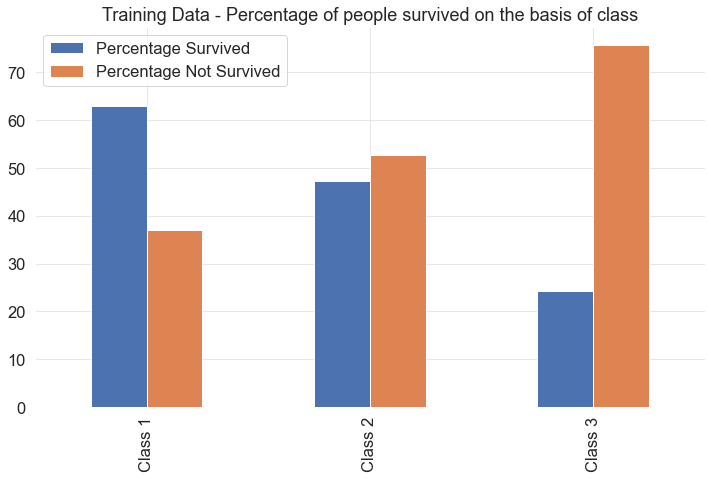

In [49]:
pclass_perc_df = pd.DataFrame({
    "Percentage Survived": {
        "Class 1": pclass_1_survivor_distribution,
        "Class 2": pclass_2_survivor_distribution, 
        "Class 3": pclass_3_survivor_distribution,
    },
    "Percentage Not Survived":{
        "Class 1": 100 - pclass_1_survivor_distribution,
        "Class 2": 100 - pclass_2_survivor_distribution, 
        "Class 3": 100 - pclass_3_survivor_distribution,
    }
})

pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")

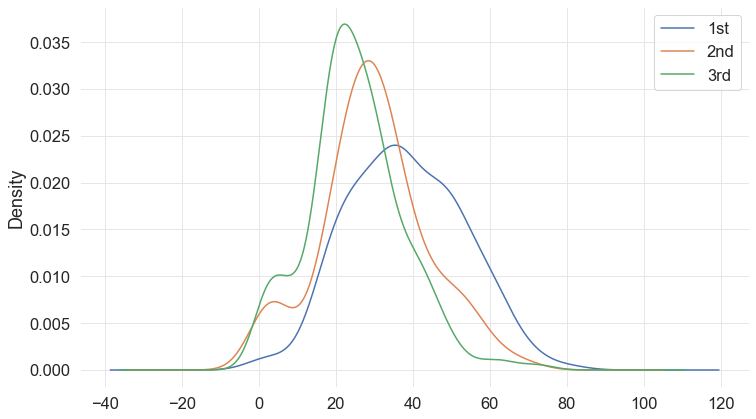

In [53]:
for pcl in (1, 2, 3):
    train_data.Age[train_data.Pclass == pcl].plot(kind="kde")
plt.legend(("1st","2nd","3rd"))